In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import numpy as np
from scipy import stats
import importlib
import src.assay_calibration.fit_utils.two_sample.fit
from src.assay_calibration.fit_utils.fit import Fit
importlib.reload(src.assay_calibration.fit_utils.two_sample.fit)
importlib.reload(src.assay_calibration.fit_utils.fit)
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints, optimize)
import scipy.stats as sps
import matplotlib
matplotlib.set_loglevel("warning")
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange
import os
sys.path.append(str(Path(os.getcwd()).parent))
from src.assay_calibration.data_utils.dataset import (
    PillarProjectDataframe,
    Scoreset,
    BasicScoreset,
)
import json
import glob

Processing BRCA2_Hu_2024
BRCA2_Hu_2024: 444 total variants
	Pathogenic/Likely Pathogenic: 48 variants
	Benign/Likely Benign: 44 variants
	gnomAD: 235 variants

method of moments succeeded
method of moments succeeded


EM Iteration:   1%|          | 70/10000 [00:00<00:43, 228.73it/s, likelihood=-1.115940]

method of moments succeeded
method of moments succeeded


EM Iteration:   1%|▏         | 129/10000 [00:00<00:44, 220.77it/s, likelihood=-1.116006]

method of moments succeeded


EM Iteration:   2%|▏         | 222/10000 [00:01<00:44, 220.74it/s, likelihood=-1.113562]

method of moments succeeded


EM Iteration:   2%|▏         | 179/10000 [00:00<00:44, 219.83it/s, likelihood=-1.113203]

method of moments succeeded


EM Iteration:   4%|▍         | 444/10000 [00:02<00:46, 204.44it/s, likelihood=-1.115928]

method of moments succeeded


EM Iteration:   0%|          | 3/10000 [00:00<06:51, 24.31it/s, likelihood=-1.609660]    

method of moments succeeded
method of moments succeeded


EM Iteration:   0%|          | 4/10000 [00:00<05:09, 32.31it/s, likelihood=-1.686182]

method of moments succeeded


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s, likelihood=-1.647693]1.398932]

method of moments succeeded


EM Iteration:   0%|          | 12/10000 [00:00<05:32, 30.08it/s, likelihood=-1.471572]

method of moments succeeded


EM Iteration:   0%|          | 1/10000 [00:00<07:32, 22.08it/s, likelihood=-1.226983]]

method of moments succeeded
method of moments succeeded


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]                               

method of moments succeeded
method of moments succeeded
method of moments succeeded
method of moments succeeded


EM Iteration:   0%|          | 26/10000 [00:00<01:21, 123.01it/s, likelihood=-1.174328]

method of moments succeeded
method of moments succeeded


EM Iteration:   1%|          | 89/10000 [00:00<01:06, 149.62it/s, likelihood=-1.170619]]

method of moments succeeded


/home/rcstewart/miniconda3/envs/assay_calibration/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s, likelihood=-1.196693]

method of moments succeeded
method of moments succeeded


EM Iteration:   0%|          | 6/10000 [00:00<07:32, 22.09it/s, likelihood=-1.194374]

method of moments succeeded


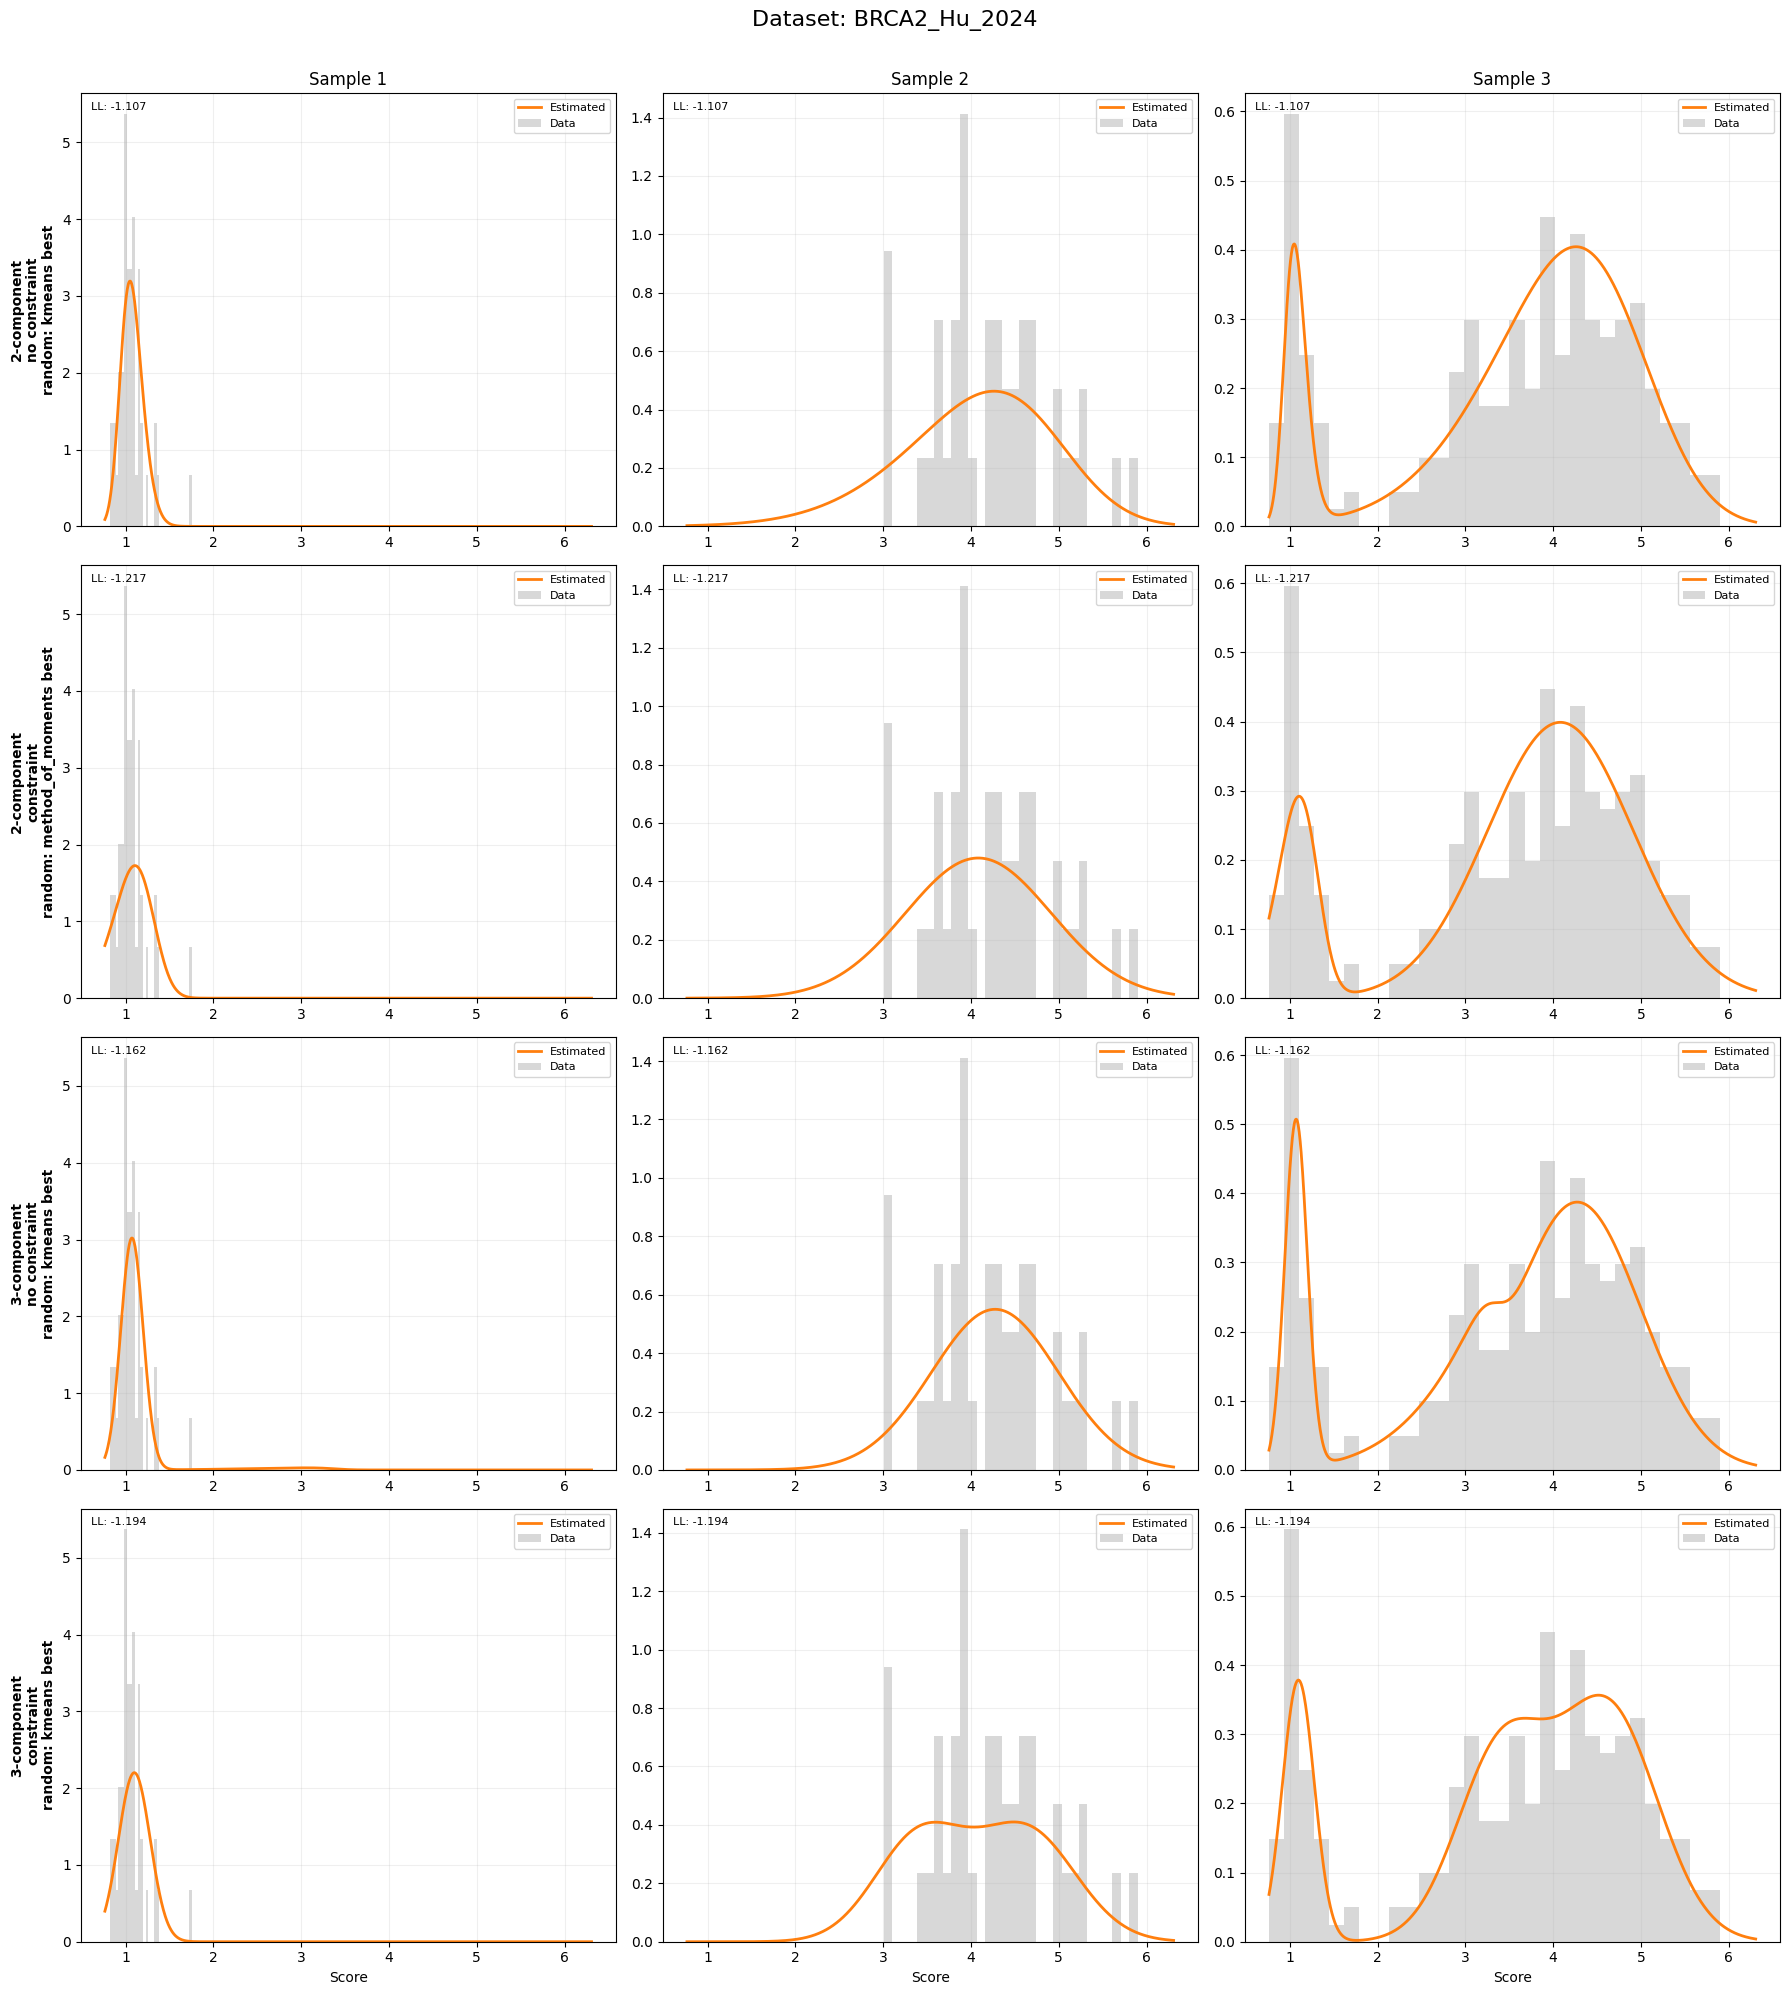

In [2]:
def test_fit(ds, component_range, check_monotonic, init_strategy):
    # Load directly from JSON
    fit = Fit(ds)
    fits = fit.run(
                core_limit=10,
                num_fits=10,
                verbose_level=20,
                component_range=component_range,
                bootstrap=False,
                verbose=False,
                max_em_iters=10000,
                check_convergence=False,
                check_monotonic=check_monotonic,
                init_strategy=init_strategy,
                score_min=ds.scores.min() - 1,
                score_max=ds.scores.max() + 1,
                # kmean_init="k-means++"
            )
    
    return fits, ds

dataset_f = "/data/ross/assay_calibration/scoresets/BRCA2_Hu_2024.json"
    
        
dataset_name = dataset_f.split('/')[-1][:-5]
print(f"Processing {dataset_name}")

ds = Scoreset.from_json(dataset_f)
print(ds)

# Create figure with 4x3 subplot grid
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle(f'Dataset: {dataset_name}', fontsize=16, y=0.995)

plot_idx = 0
for component_range in ("2-component", "3-component"):
    for monotonicity_constraint in ("no constraint", "constraint"):
        for init_strategy in ["random"]:#,"kmeans"):
            
            # Run the fit
            # try:
            fits, ds = test_fit(
                ds, 
                component_range=[3] if component_range[0] == "3" else [2], 
                check_monotonic=False if monotonicity_constraint[0] == "n" else True, 
                init_strategy=init_strategy
            )
            
            # Get best fit
            fit_results = sorted(fits, key=lambda res: res['likelihoods'][-1], reverse=True)
            best_fit = fit_results[0]
            best_init = "method_of_moments best" if best_fit['kmeans'] == "method_of_moments" else "kmeans best"
            scores = ds.scores
            sample_assignments = ds.sample_assignments
            
            # Calculate densities
            score_range = np.linspace(scores.min(), scores.max(), 1000)
            estimatedDensities = np.array([
                density_utils.joint_densities(
                    score_range[..., None],
                    best_fit['component_params'],
                    sample_weights
                ).squeeze() for sample_weights in best_fit['weights']
            ])
            
            # Plot for each sample (3 columns)
            for i in range(3):
                ax = axes[plot_idx, i]
                
                # Plot estimated density
                ax.plot(score_range, estimatedDensities[i].sum(0), 
                       label='Estimated', color='C1', linestyle='-', linewidth=2)
                
                # Plot histogram of actual data
                if i < sample_assignments.shape[1] and sample_assignments[:, i].sum() > 0:
                    ax.hist(scores[sample_assignments[:, i]], 
                           bins=30, density=True, alpha=0.3, 
                           color='gray', label='Data')
                
                # Set labels and title
                if i == 0:
                    ax.set_ylabel(f'{component_range}\n{monotonicity_constraint}\n{init_strategy}: {best_init}', 
                                 fontsize=10, fontweight='bold')
                
                if plot_idx == 0:
                    ax.set_title(f'Sample {i+1}', fontsize=12)
                
                if plot_idx == 3:
                    ax.set_xlabel('Score', fontsize=10)
                
                ax.legend(loc='upper right', fontsize=8)
                ax.grid(True, alpha=0.2)
                
                # Add likelihood value as text
                likelihood = best_fit['likelihoods'][-1]
                ax.text(0.02, 0.98, f'LL: {likelihood:.3f}', 
                       transform=ax.transAxes, fontsize=8,
                       verticalalignment='top')
                
            # except Exception as e:
            #     print(f"  Error with {component_range}, {monotonicity_constraint}: {e}")
            #     # Create empty plots with error message
            #     for i in range(3):
            #         ax = axes[plot_idx, i]
            #         ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}...', 
            #                ha='center', va='center', transform=ax.transAxes)
            #         ax.set_xticks([])
            #         ax.set_yticks([])
                    
            #         if i == 0:
            #             ax.set_ylabel(f'{component_range}\n{monotonicity_constraint}', 
            #                          fontsize=10, fontweight='bold')
            #         if plot_idx == 0:
            #             ax.set_title(f'Sample {i+1}', fontsize=12)
        
        plot_idx += 1

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.99])

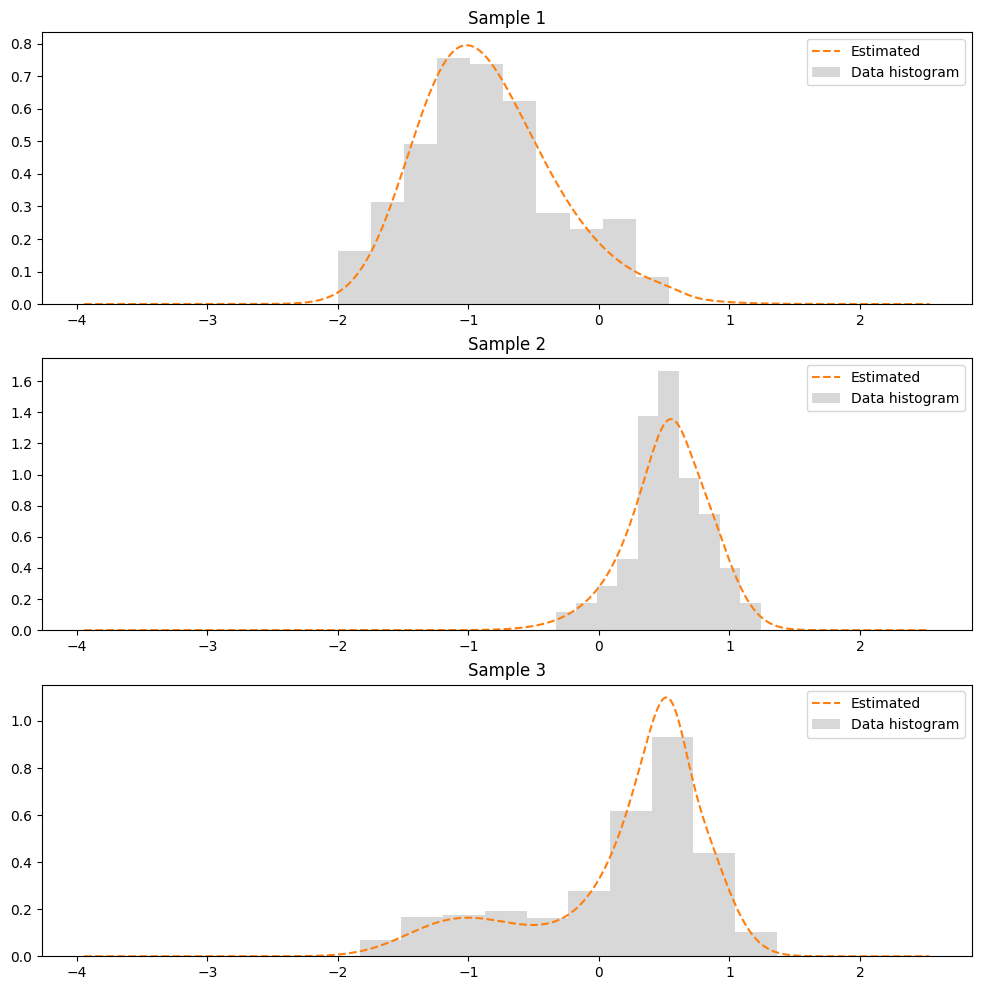

In [16]:
constraints.multicomponent_density_constraint_violated(best_fit['component_params'],
                                                       score_range[[0,-1]])

True

In [17]:
best_fit.keys()

dict_keys(['component_params', 'weights', 'likelihoods', 'history', 'kmeans'])

In [18]:
best_fit['component_params']

[(2.119934944668942, -1.4066969961718965, 0.7485391961046397),
 (-4.139130269323909, 0.6291170844316567, 0.44865196432343213),
 (-0.6862518318288323, 0.8012973200875664, 0.29211226835878934)]

In [10]:
scores.min(),scores.max()

(np.float64(-3.943922004719567), np.float64(2.533066896905726))